# ARM - GD - Data Preprocessing and Model Training

This script runs the Google dataset from the Kaggle competition.
- https://www.kaggle.com/competitions/asl-signs

It will do the following tasks:
- Load the landmarks.
- Preprocess the landmarks.
- Select the best architecture and tune the hyperparameters.
- Train the final model.

Created by:
- Marcus Vinicius da Silva Fernandes.

2023-07-24.

ARM = Action Recognition Modelling.
GD = Google Dataset.

References:
- https://www.kaggle.com/code/jessevanderlinden/basic-lstm-and-transformer-implementation
- https://www.kaggle.com/code/jvthunder/lstm-baseline-for-starters-sign-language
- https://www.kaggle.com/code/stanptown/lstm-baseline-for-starters-sign-language-eeff0f
- https://www.kaggle.com/code/hoyso48/1st-place-solution-training
- https://www.kaggle.com/competitions/asl-signs/discussion/406306
- https://www.youtube.com/watch?v=doDUihpj6ro

## Importing the libraries for data preprocessing

In [1]:
import numpy as np
import pandas as pd
import json
import os
import csv
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

## Using TPU

In [2]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

D0813 01:06:16.417561568      16 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0813 01:06:16.417584669      16 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0813 01:06:16.417587937      16 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0813 01:06:16.417590485      16 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0813 01:06:16.417592947      16 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0813 01:06:16.417595521      16 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0813 01:06:16.417598012      16 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0813 01:06:16.

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


In [3]:
!pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.0/39.0 MB 13.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## Reproducibility of the results

Setting the random seed for the random number generators used in the code, to ensure that the random processes, likd data shuffling or weight initialization, produce the same results every time we run the notebook.

In [4]:
import random

random.seed(42)
np.random.seed(42)

## Loading the data

### Accessing the landmarks
- Set up the paths of folders to locate the landmarks and the list (csv file) that associates the name of the video to the corresponding word in English.
- Creation of a dictionary to associate the words to a unique number.

In [5]:
# Set up of the extracted landmarks save path
# landmarks_path = 'C:/asl-signs/'
landmarks_path = '/kaggle/input/asl-signs/'

In [6]:
# Opening the file train.csv to load the association of sequence ids to words
train_csv = pd.read_csv(landmarks_path + 'train.csv')
train_csv

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room


In [7]:
# Loading the json file adn creation of dictionary to associate the words to a unique number
with open(landmarks_path + 'sign_to_prediction_index_map.json', 'r') as j:
     sign_dict = json.loads(j.read())

del j

### Loading and shaping the landmarks to the desired number of frames

#### Desired number of frames
- Each video will be reshaped to have the number of rows (or frames) equal to the desired number of frames defined below.

In [8]:
NUM_FRAMES = 30

#### Landmark points to keep
- The objective is to reduce the number of features.
- All the landmarks from the hands will be kept.
- Other landmarks to keep: outline of mouth from face mesh model, and arms, shoulders, and face from pose model.

In [9]:
face_keep_points = [0, 267, 269, 270, 409, 291, 375, 321, 405, 314, 17, 84, 181, 91, 146, 61, 185, 40, 39, 37]
face_keep_points.sort()
left_hand_keep_points = [i for i in range(21)]
pose_keep_points = [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 23, 24]
right_hand_keep_points = [i for i in range(21)]

face_keep_idx = [face_keep_points[i] for i in range(len(face_keep_points))]
left_hand_keep_idx = [i + 468 for i in left_hand_keep_points]
pose_keep_idx = [i + 468 + 21 for i in pose_keep_points]
right_hand_keep_idx = [i + 468 + 21 + 33 for i in right_hand_keep_points]

landmarks_to_keep = face_keep_idx + left_hand_keep_idx + pose_keep_idx + right_hand_keep_idx

del face_keep_points, left_hand_keep_points, pose_keep_points, right_hand_keep_points
del face_keep_idx, left_hand_keep_idx, pose_keep_idx, right_hand_keep_idx

In [10]:
TOTAL_ROWS = 543
desired_num_rows = len(landmarks_to_keep) * 2

#### Loading all the landmarks
- The 'z' coordinate will be dropped because, according to Google, it “should be discarded as currently the model is not fully trained to predict depth”.

In [11]:
def load_landmarks():
    # Getting the files to load
    file = landmarks_path + train_csv['path'].values#[:3]
    word = train_csv['sign'].values#[:3]

    # Columns to upload
    data_columns = ['x', 'y']

    landmarks = np.empty((file.shape[0], NUM_FRAMES, desired_num_rows), dtype=float)
    labels = []
    
    for i in tqdm(range(file.shape[0])):

        # Loading the file
        data = pd.read_parquet(file[i], columns=data_columns).fillna(0)
        num_frames = int(len(data) / TOTAL_ROWS)
        data = data.values.reshape(num_frames, TOTAL_ROWS, len(data_columns))
        data.astype(np.float32)

        # Dropping undesired points
        data = data[:, landmarks_to_keep]

        # Adjusting the number of frames
        if data.shape[0] > NUM_FRAMES:  # time-based sampling
            indices = np.arange(0, data.shape[0], data.shape[0] // NUM_FRAMES)[:NUM_FRAMES]
            data = data[indices]
        elif data.shape[0] < NUM_FRAMES:  # padding the videos
            rows = NUM_FRAMES - data.shape[0]
            data = np.append(np.zeros((rows, len(landmarks_to_keep), len(data_columns))), data, axis=0)

        # Reshaping the data
        landmarks[i] = data.reshape(NUM_FRAMES, len(landmarks_to_keep) * len(data_columns), order='F')
        del data

        # Creating the labels dataset
        labels.append(sign_dict[word[i]])
    return landmarks, np.array(labels)

x_train, y_train = load_landmarks()

100%|██████████| 94477/94477 [25:18<00:00, 62.23it/s]


## Splitting the data into train, val, and test datasets
- 90% for train, 5% for validation, and 5% for testing.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [13]:
x_train, x_val_test, y_train, y_val_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42)

In [14]:
del x_val_test, y_val_test
# del x_test, y_test

In [15]:
x_train.shape

(85029, 30, 158)

## One-hot encoding the y datasets

In [16]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_val = label_binarizer.transform(y_val)
y_test = label_binarizer.transform(y_test)

del label_binarizer

In [17]:
y_train.shape

(85029, 250)

## Model build

### Importing the libraries for modelling

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LayerNormalization, Activation, Dropout, LSTM, Masking
from keras.optimizers import Adam

### Building and training the model

In [28]:
with tpu_strategy.scope():
    input_shape = (None, x_train.shape[2])
    output_classes = y_train.shape[1]

    model = Sequential()

    model.add(Masking(mask_value=0, input_shape=input_shape))

    model.add(Dense(512))
    model.add(LayerNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(256))
    model.add(LayerNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(256))
    model.add(Dropout(0.4))

    model.add(Dense(256, activation='relu'))

    model.add(Dense(output_classes, activation='softmax'))

    model.summary()
    
    learning_rate = 0.001
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, None, 158)         0         
                                                                 
 dense_4 (Dense)             (None, None, 512)         81408     
                                                                 
 layer_normalization_2 (Laye  (None, None, 512)        1024      
 rNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, None, 512)         0         
                                                                 
 dropout_4 (Dropout)         (None, None, 512)         0         
                                                                 
 dense_5 (Dense)             (None, None, 256)         131328    
                                                      

2023-08-13 02:33:33.078091: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-08-13 02:33:33.380951: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


2658/2658 [==============================] - ETA: 0s - loss: 5.5225 - accuracy: 0.0038

2023-08-13 02:34:24.385931: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-13 02:34:24.601000: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


2658/2658 [==============================] - 63s 19ms/step - loss: 5.5225 - accuracy: 0.0038 - val_loss: 5.4945 - val_accuracy: 0.0044
Epoch 2/100
2658/2658 [==============================] - 40s 15ms/step - loss: 5.1394 - accuracy: 0.0188 - val_loss: 4.5882 - val_accuracy: 0.0483
Epoch 3/100
2658/2658 [==============================] - 39s 15ms/step - loss: 4.4487 - accuracy: 0.0655 - val_loss: 4.1481 - val_accuracy: 0.1069
Epoch 4/100
2658/2658 [==============================] - 40s 15ms/step - loss: 4.1607 - accuracy: 0.1029 - val_loss: 3.9471 - val_accuracy: 0.1296
Epoch 5/100
2658/2658 [==============================] - 40s 15ms/step - loss: 3.9676 - accuracy: 0.1299 - val_loss: 3.7364 - val_accuracy: 0.1657
Epoch 6/100
2658/2658 [==============================] - 40s 15ms/step - loss: 3.8334 - accuracy: 0.1496 - val_loss: 3.6510 - val_accuracy: 0.1787
Epoch 7/100
2658/2658 [==============================] - 39s 15ms/step - loss: 3.6777 - accuracy: 0.1735 - val_loss: 3.4968 - val_

In [29]:
# Accessing the training and validation accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

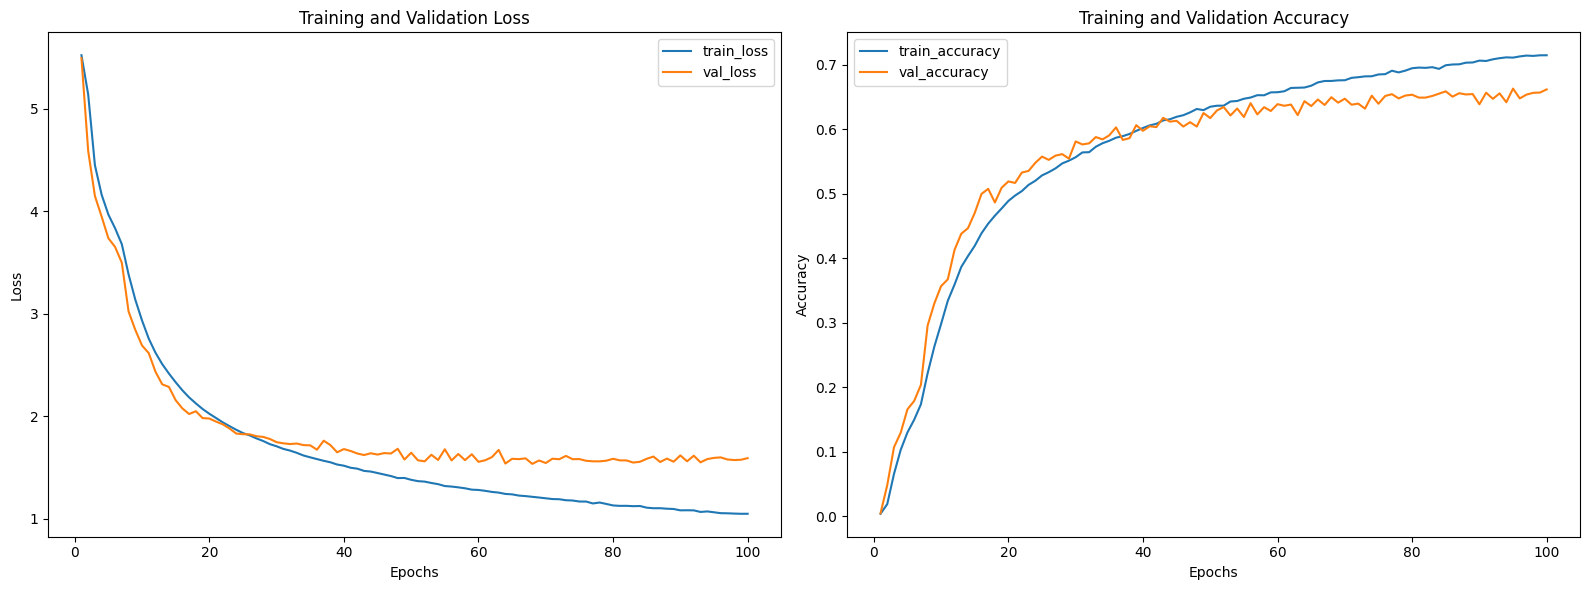

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

x = [i for i in range (1, len(train_accuracy) + 1)]

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting the lines on the first subplot
ax1.plot(x, train_loss, label='train_loss')
ax1.plot(x, val_loss, label='val_loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plotting the lines on the second subplot
ax2.plot(x, train_accuracy, label='train_accuracy')
ax2.plot(x, val_accuracy, label='val_accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

# Adjust the layout to avoid overlapping titles and labels
plt.tight_layout()

# Display the plots
plt.show()

## Predictions with test datasets

In [31]:
# Making predictions
predicted_labels = model.predict(x_test)

# Getting the predicted labels and words
predicted_labels = np.argmax(predicted_labels, axis=1)
predicted_words = np.array([list(sign_dict.keys())[list(sign_dict.values()).index(label)] for label in predicted_labels])

# Printing the predicted words
# print('Predicted words:')
# print(predicted_words)

2023-08-13 03:39:46.706084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-13 03:39:46.889179: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


148/148 [==============================] - 6s 13ms/step


In [32]:
from sklearn.metrics import accuracy_score

In [33]:
# Calculating the accuracy score
accuracy = accuracy_score(np.argmax(y_test, axis=1), predicted_labels)

# Printing the accuracy score
print("Test Dataset Accuracy:", accuracy)

Test Dataset Accuracy: 0.6507197290431838


## Save the model

In [36]:
# Save the trained model to an h5 file
model.save("08-12_ARM_GD_Final-Architecture.h5")

## Hyperparameter tuning

### Tuning the units

In [53]:
# from kerastuner.tuners import Hyperband

# # Define a function to build the model with hyperparameters
# def build_model(hp):
#     input_shape = (None, x_train.shape[2])
#     output_classes = y_train.shape[1]

#     model = Sequential()
#     model.add(Dense(units=hp.Int('units_dense_1', min_value=32, max_value=576, step=32), input_shape=input_shape))
#     model.add(LayerNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(hp.Float('dropout_dense_1', min_value=0.0, max_value=0.8, step=0.1)))

#     model.add(Dense(units=hp.Int('units_dense_2', min_value=32, max_value=512, step=32)))
#     model.add(LayerNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(hp.Float('dropout_dense_2', min_value=0.0, max_value=0.8, step=0.1)))

#     model.add(LSTM(units=hp.Int('units_lstm_1', min_value=64, max_value=512, step=32), return_sequences=True))
#     model.add(Dropout(hp.Float('dropout_lstm_1', min_value=0.0, max_value=0.8, step=0.1)))

#     model.add(LSTM(units=hp.Int('units_lstm_2', min_value=64, max_value=512, step=32)))
#     model.add(Dropout(hp.Float('dropout_lstm_2', min_value=0.0, max_value=0.8, step=0.1)))

#     model.add(Dense(units=hp.Int('units_dense_3', min_value=32, max_value=512, step=32), activation='relu')) 

#     model.add(Dense(output_classes, activation='softmax'))    

#     # Compile the model
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#     return model

# # Create a tuner object with Hyperband
# tuner = Hyperband(
#     build_model,
#     objective='val_accuracy',  # Use 'val_loss' or 'val_accuracy' depending on your preference
#     max_epochs=10,  # Maximum number of epochs per trial
#     factor=3,  # Reduction factor for the number of models at each iteration
#     directory='my_dir',  # Directory to store the results
#     project_name='my_project'  # Name for this tuning experiment
# )

# # Perform the hyperparameter search
# tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# # Get the best hyperparameters and build the final model
# best_hp = tuner.get_best_hyperparameters(1)[0]
# model = build_model(best_hp)

# model.summary()


Trial 30 Complete [00h 08m 36s]
val_accuracy: 0.28429296612739563

Best val_accuracy So Far: 0.54826420545578
Total elapsed time: 01h 55m 06s
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, None, 320)         50880     
                                                                 
 layer_normalization_2 (Laye  (None, None, 320)        640       
 rNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, None, 320)         0         
                                                                 
 dropout_4 (Dropout)         (None, None, 320)         0         
                                                                 
 dense_5 (Dense)             (None, None, 128)         41088     
                                            

In [54]:
# best_hp.values

{'units_dense_1': 320,
 'dropout_dense_1': 0.0,
 'units_dense_2': 128,
 'dropout_dense_2': 0.0,
 'units_lstm_1': 224,
 'dropout_lstm_1': 0.4,
 'units_lstm_2': 352,
 'dropout_lstm_2': 0.0,
 'units_dense_3': 256,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0012'}

In [55]:
# tuner.results_summary()

Results summary
Results in my_dir/my_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0016 summary
Hyperparameters:
units_dense_1: 320
dropout_dense_1: 0.0
units_dense_2: 128
dropout_dense_2: 0.0
units_lstm_1: 224
dropout_lstm_1: 0.4
units_lstm_2: 352
dropout_lstm_2: 0.0
units_dense_3: 256
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.54826420545578

Trial 0024 summary
Hyperparameters:
units_dense_1: 64
dropout_dense_1: 0.0
units_dense_2: 32
dropout_dense_2: 0.1
units_lstm_1: 416
dropout_lstm_1: 0.8
units_lstm_2: 224
dropout_lstm_2: 0.30000000000000004
units_dense_3: 448
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 0.544030487537384

Trial 0025 summary
Hyperparameters:
units_dense_1: 192
dropout_dense_1: 0.2
units_dense_2: 96
dropout_dense_2: 0.30000000000000004
units_lstm_1: 320
dropout_lstm_1: 0.4
units_lstm_2: 320
dropout_lstm_2: 0.60000